In [15]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
# from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.model_selection import train_test_split

c:\Users\laure\anaconda3\envs\loopr_env\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
source_dir = "C:/Users/laure/Documents/proj_loopr/processed_images"

def retrieve_images(fil_dir):
    sample_list = os.listdir(fil_dir)
    img_list = np.zeros((len(sample_list),7,40,500))
    ind = 0
    for file_name in sample_list:
        img_list[ind,:,:,:] = np.load(os.path.join(fil_dir,file_name))
        ind+=1
    return img_list

def retrieve_classes(fil_dir):
    sample_list = os.listdir(fil_dir)
    class_list = np.zeros(len(sample_list))
    ind = 0
    for file_name in sample_list:
        if file_name[5:8] != "000":
            class_list[ind] = 1 #int(file_name[5:8])
        ind+=1
    return class_list

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # img size = 7 x 40 x 500
        self.conv1 = nn.Conv2d(7, 16, kernel_size =(2,4),stride=(1,2)) #16 x 39 x 249
        self.conv2 = nn.Conv2d(16, 32,kernel_size =(2,3),stride=(1,2)) #32 x 38 x 124
        self.conv3 = nn.Conv2d(32, 32,kernel_size =(2,4),stride=2) #32 x 19 x 61
        self.pool = nn.MaxPool2d(3, stride=2) #32 x 9 x 30

        self.fc1 = nn.Linear( 8640, 1920)  
        self.fc2 = nn.Linear( 1920, 120)   
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x,1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x), dim=1)
        return x

net = Net()

In [4]:
xs = retrieve_images(source_dir)

In [5]:
ys = retrieve_classes(source_dir)

In [6]:
labels = np.zeros((xs.shape[0], 2))
labels[:,1] = ys
labels[np.argwhere(ys==0).flatten(),0] = 1


In [7]:
X_train, X_test, y_train, y_test = train_test_split(xs, labels, test_size=0.1, random_state=81)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=81)


In [8]:
np.sum(y_val[:,1])

17.0

In [9]:
criterion  = nn.CrossEntropyLoss() #DiceLoss()
optimizer = optim.Adam(net.parameters(), lr=5e-5)

In [11]:
train_dataset = TensorDataset(torch.from_numpy(X_train).type(torch.FloatTensor), torch.from_numpy(y_train))
train_loader = DataLoader(train_dataset,batch_size=5,sampler = RandomSampler(train_dataset, replacement=False)) 
val_dataset = TensorDataset(torch.from_numpy(X_val).type(torch.FloatTensor), torch.from_numpy(y_val))
val_loader = DataLoader(val_dataset, batch_size=5) 

In [14]:
# batch_size=5
total_epochs = 60
losses = np.zeros(total_epochs)
val_losses = np.zeros(total_epochs)
for epoch in range(total_epochs):  # loop over the dataset multiple times

    running_loss = 0.0

    # rand_list = np.arange(mask_list.shape[0])
    # np.random.shuffle(rand_list)

    # new_img_list = img_list[rand_list,:,:]
    # new_labels = labels[rand_list,:]
    
    for batch, (inputs, lab) in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        # inputs = torch.from_numpy(new_img_list[i*batch_size:(i+1)*batch_size,:,:].reshape(batch_size,1,32,32))
        # lab = torch.tensor(new_labels[i*batch_size:(i+1)*batch_size,:])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, lab)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % 2000 == 1999:    # print every 2000 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        #     running_loss = 0.0 
    
    with torch.no_grad():
        for batch, (val_inputs, val_labels) in enumerate(val_loader):#val_sample in test_loader:
        #         #val_features, val_labels = next(iter(test_loader))
            val_outputs = net(val_inputs)
            valloss = criterion(val_outputs, val_labels)
            val_losses[epoch] +=valloss.item()

    print("Epoch "+str(epoch+1)+": \n Training Loss is: "+str(running_loss))
    print(" Validation Loss is: "+str(val_losses[epoch] ))
    losses[epoch] = running_loss
print('Finished Training')

Epoch 1: 
 Training Loss is: 24.92071809768677
 Validation Loss is: 6.073798894882202
Epoch 2: 
 Training Loss is: 24.860268485546108
 Validation Loss is: 6.073798894882202
Epoch 3: 
 Training Loss is: 24.851715189218517
 Validation Loss is: 6.073798894882202
Epoch 4: 
 Training Loss is: 24.802838939428334
 Validation Loss is: 6.073798894882202
Epoch 5: 
 Training Loss is: 24.856621450185774
 Validation Loss is: 6.073798894882202
Epoch 6: 
 Training Loss is: 24.931165015697474
 Validation Loss is: 6.073798894882202
Epoch 7: 
 Training Loss is: 24.788185679912562
 Validation Loss is: 6.073798894882202
Epoch 8: 
 Training Loss is: 24.913900667428972
 Validation Loss is: 6.073798894882202
Epoch 9: 
 Training Loss is: 24.906549620628358
 Validation Loss is: 6.073798894882202
Epoch 10: 
 Training Loss is: 24.840916591882703
 Validation Loss is: 6.073798894882202
Epoch 11: 
 Training Loss is: 24.785520768165586
 Validation Loss is: 6.073798894882202
Epoch 12: 
 Training Loss is: 24.898490637

In [26]:
appl = transforms.RandomAffine(0,(0.95,0.3))

In [27]:
out = appl(torch.from_numpy(X_train[6,:,:,:])).numpy()

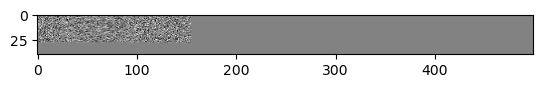

In [30]:
plt.figure()
plt.imshow(out[6,:,:],cmap="gray")
plt.show()